# Dataset.py debugging

In [2]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
from config import CLASSES, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
from custom_utils import collate_fn, get_train_transform, get_valid_transform
import matplotlib.pyplot as plt

# Utility function to display an image using matplotlib
def show_image(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Custom Dataset Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dir_path, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []
        
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.dir_path, file_type)))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        while True:
            try:
                image_name = self.all_images[idx]
                image_path = os.path.join(self.dir_path, image_name)
                image = cv2.imread(image_path)
                
                if image is None:
                    print(f"Failed to load image at {image_path}")
                    idx = (idx + 1) % len(self.all_images)
                    continue
                
                # Display image before processing
                show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title="Before Processing")
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
                image /= 255.0
                
                # Display image after normalization
                show_image(image, title="After Normalization")

                annot_filename = os.path.splitext(image_name)[0] + '.xml'
                annot_file_path = os.path.join(self.dir_path, annot_filename)
                
                boxes = []
                labels = []
                tree = et.parse(annot_file_path)
                root = tree.getroot()
                
                image_width = image.shape[1]
                image_height = image.shape[0]
                
                for member in root.findall('object'):
                    labels.append(self.classes.index(member.find('name').text))
                    
                    xmin = int(member.find('bndbox').find('xmin').text) / image_width
                    xmax = int(member.find('bndbox').find('xmax').text) / image_width
                    ymin = int(member.find('bndbox').find('ymin').text) / image_height
                    ymax = int(member.find('bndbox').find('ymax').text) / image_height
                    
                    if xmax > xmin and ymax > ymin:
                        boxes.append([xmin, ymin, xmax, ymax])
                
                if len(boxes) != len(labels):
                    print(f"Mismatch between boxes and labels at {annot_file_path}")
                    idx = (idx + 1) % len(self.all_images)
                    continue
                
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.as_tensor(boxes, dtype=torch.float32)
                iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
                labels = torch.as_tensor(labels, dtype=torch.int64)

                target = {"boxes": boxes, "labels": labels, "area": area, "iscrowd": iscrowd, "image_id": torch.tensor([idx])}

                if self.transforms:
                    sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
                    image = sample['image']
                    target['boxes'] = torch.Tensor(sample['bboxes'])

                return image, target
            except Exception as e:
                print(f"Error processing {image_name}: {e}")
                idx = (idx + 1) % len(self.all_images)
                continue

    def __len__(self):
        return len(self.all_images)


# Prepare Dataset and Dataloaders

In [5]:
# Prepare the final datasets and data loaders
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, CLASSES, get_train_transform()
    )
    return train_dataset

def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, CLASSES, get_valid_transform()
    )
    return valid_dataset

def create_test_dataset(DIR):
    test_dataset = CustomDataset(
        DIR, CLASSES, get_valid_transform()
    )
    return test_dataset

def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader

def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader

def create_test_loader(test_dataset, num_workers=0):
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return test_loader


In [ ]:
dataset = CustomDataset(
    '/home/jupyter/ee_tree_counting/Data/Combined Dataset XML No Aug/train', CLASSES 
)
print(f"Number of training images: {len(dataset)}")

def visualize_sample(image, target):
    image_copy = image.copy()
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        cv2.rectangle(
            image_copy, 
            (int(box[0] * image_copy.shape[1]), int(box[1] * image_copy.shape[0])), 
            (int(box[2] * image_copy.shape[1]), int(box[3] * image_copy.shape[0])),
            (255, 0, 0), 
            2
        )
        cv2.putText(
            image_copy, 
            label, 
            (int(box[0] * image_copy.shape[1]), int(box[1] * image_copy.shape[0]) - 5), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, 
            (255, 0, 0), 
            2
        )
    show_image(image_copy, title="Annotated Image")

NUM_SAMPLES_TO_VISUALIZE = 3
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)


#### Visualisation issue:The original image data was normalized to the range [0, 1] and had a float32 data type. The OpenCV functions cv2.rectangle and cv2.putText expect image data in the range [0, 255] with an uint8 data type.
#### The solution involved scaling the image data back to the [0, 255] range and converting it to uint8 before drawing the bounding boxes and labels.

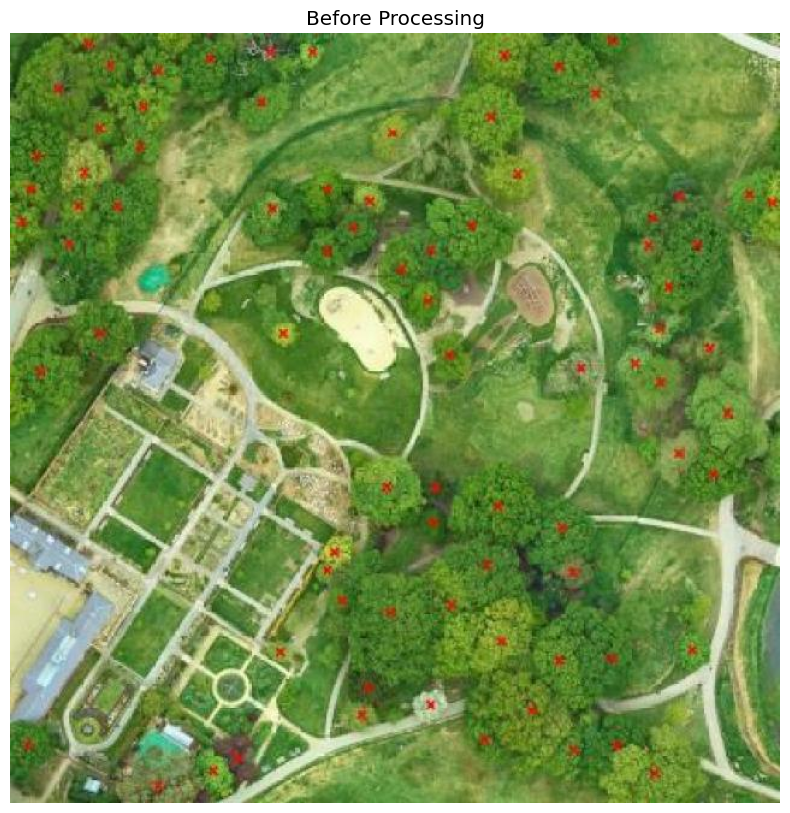

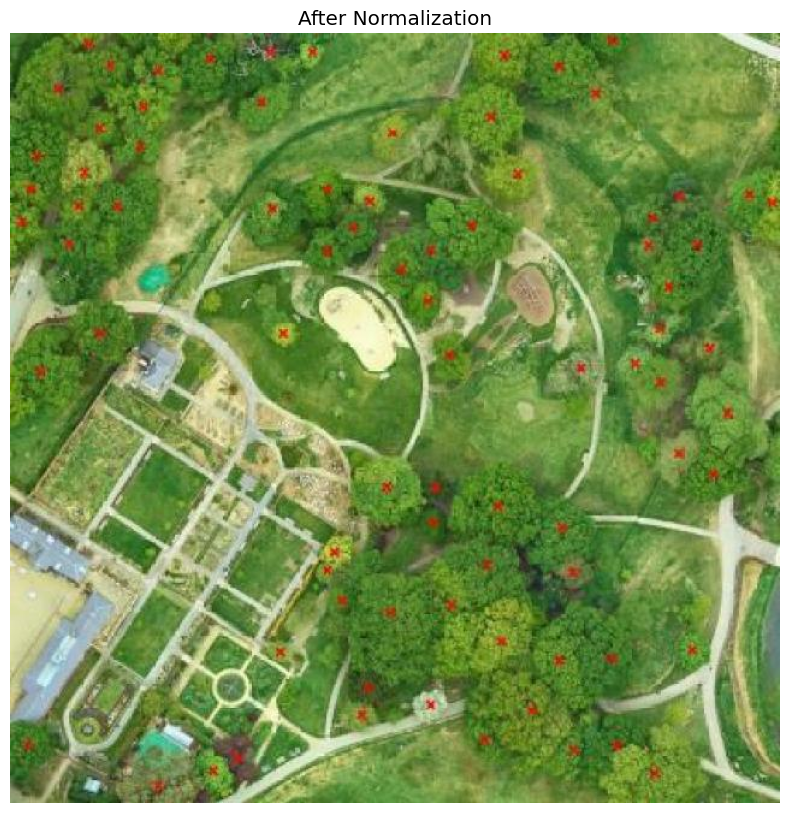

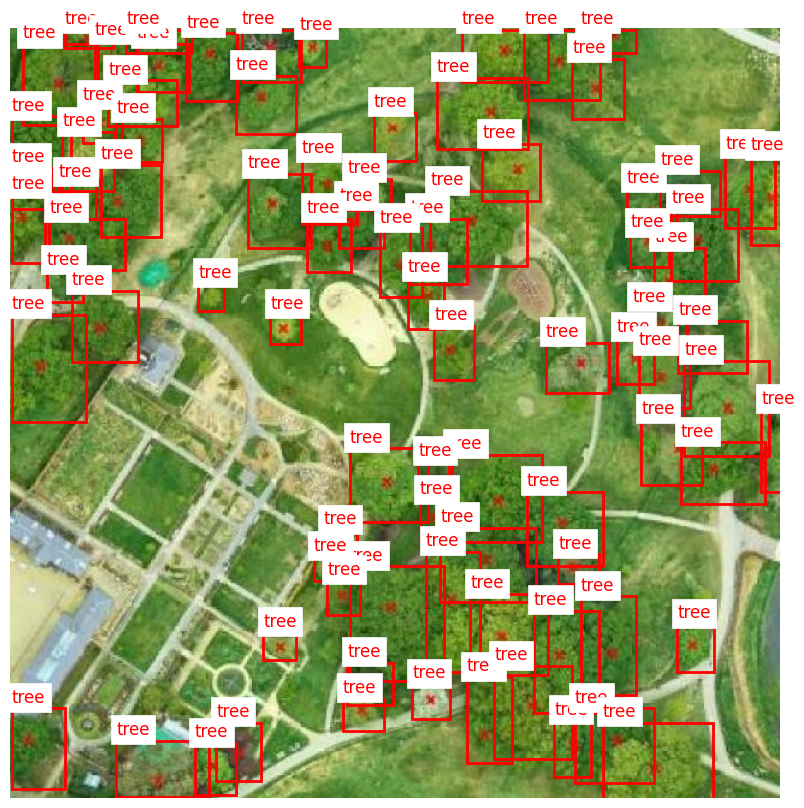

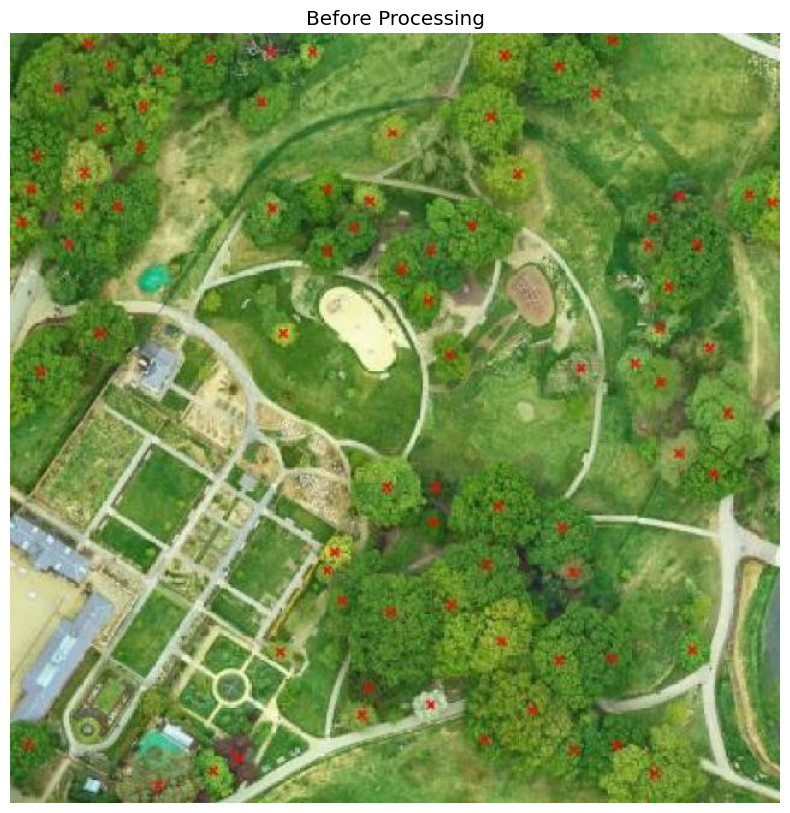

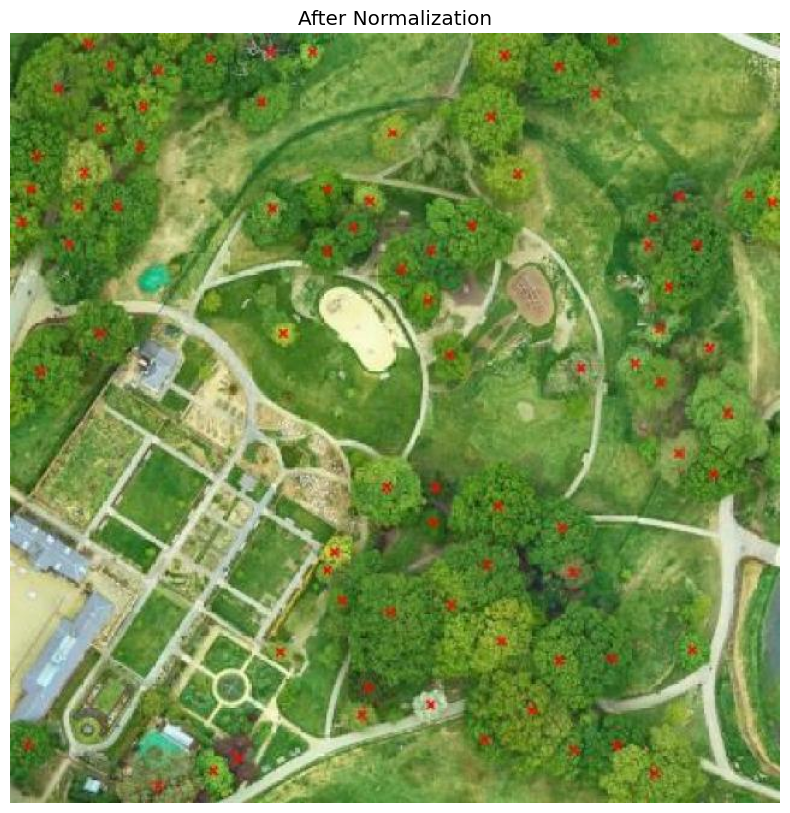

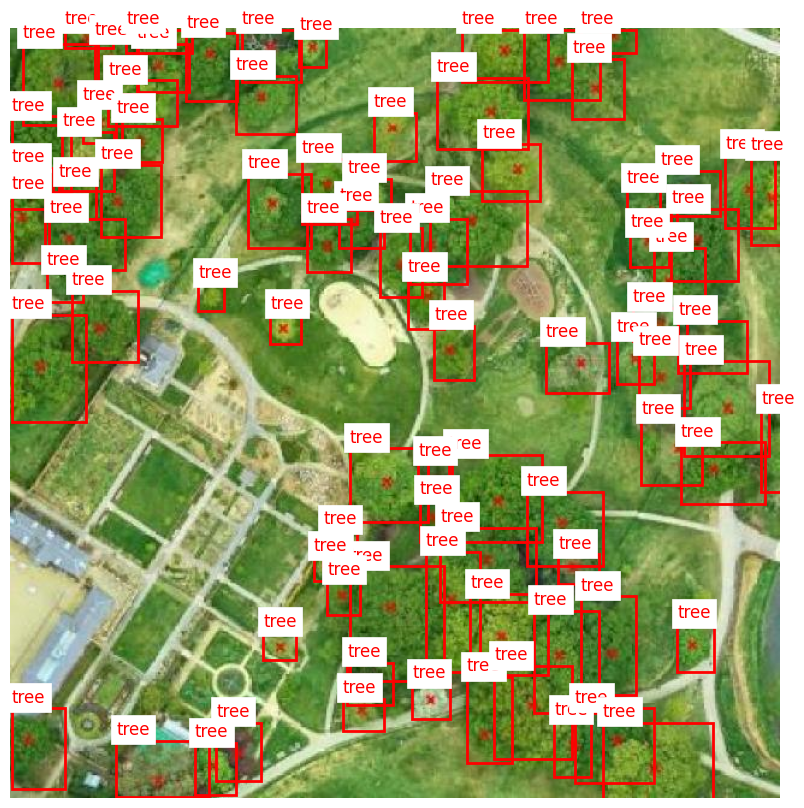

In [9]:

def show_image_with_annotations(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        x1, y1, x2, y2 = box
        x1 = int(x1 * image.shape[1])
        y1 = int(y1 * image.shape[0])
        x2 = int(x2 * image.shape[1])
        y2 = int(y2 * image.shape[0])
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=2))
        plt.text(x1, y1 - 5, CLASSES[label], color='red', fontsize=12, backgroundcolor='white')
    plt.axis('off')
    plt.show()

def inspect_dataset_samples(dataset, num_samples=2):
    for i in range(num_samples):
        image, target = dataset[i]
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()
        show_image_with_annotations(image, boxes, labels)

inspect_dataset_samples(dataset)
